# Mutation spectrum and rates at four-fold synonymous sites
Analyze the mutation rates and spectrum only at four-fold synonymous sites, as defined in relation to the founder sequence for that clade.

Import Python modules:

In [1]:
import itertools
import os

import altair as alt

import numpy

import pandas as pd

import yaml

import scipy

import sklearn.decomposition

Get input variables from [papermill](https://papermill.readthedocs.io/) parameterization (note next cell is tagged as `parameters`).
So when this notebook is run via `papermill`, those values will be replaced with whatever is in pipeline:

In [2]:
mutation_counts_csv = "../results/mutation_counts/aggregated.csv"
clade_founder_nts_csv = "../results/clade_founder_nts/clade_founder_nts.csv"
rates_by_clade_csv = "../results/synonymous_mut_rates/rates_by_clade.csv"
rates_plot = "../results/synonymous_mut_rates/rates_plot.html"

with open("config.yaml" if os.path.isfile("config.yaml") else "../config.yaml") as f:
    config = yaml.safe_load(f)
    
synonymous_spectra_min_counts = config["synonymous_spectra_min_counts"]
subset_order = list(config["sample_subsets"])
clade_synonyms = config["clade_synonyms"]

Read the mutation counts and assign mutation types:

In [99]:
mutation_counts = pd.read_csv(mutation_counts_csv).assign(
    mut_type=lambda x: x["nt_mutation"].map(lambda m: f"{m[0]}to{m[-1]}")
)

mutation_counts.head()

,protein,aa_mutation,nt_mutation,codon_change,synonymous,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,...,count_terminal,count_non_terminal,mean_log_size,clade,subset,codon,codon_position,codon_site,four_fold_degenerate,mut_type
0,ORF1ab,P5401L,C16466T,CCA>CTA,False,16466,C,C,False,not excluded,...,33,30,0.709464,19A,all,CCA,2,5401,False,CtoT
1,M,I82T,T26767C,ATC>ACC,False,26767,T,T,False,not excluded,...,19,35,1.160612,19A,all,ATC,2,82,False,TtoC
2,ORF1a;ORF1ab,F924F;F924F,C3037T,TTC>TTT;TTC>TTT,True,3037,C,C,False,not excluded,...,25,24,0.723654,19A,all,TTC;TTC,3;3,924;924,False,CtoT
3,ORF1ab,A6319V,C19220T,GCT>GTT,False,19220,C,C,False,not excluded,...,14,33,1.123765,19A,all,GCT,2,6319,False,CtoT
4,ORF1ab,P4715L,C14408T,CCT>CTT,False,14408,C,C,False,not excluded,...,22,24,0.698993,19A,all,CCT,2,4715,False,CtoT


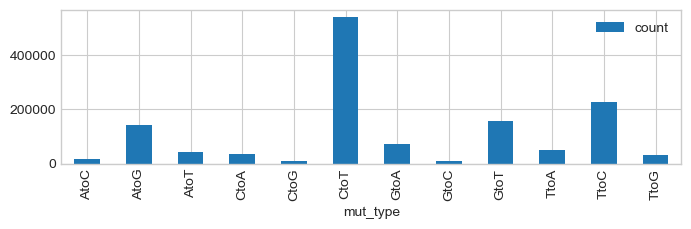

In [97]:
# djp
df_mut_counts = (
    mutation_counts.query("synonymous")
    .query("four_fold_degenerate")
    .query("not exclude")
)
df_mut_counts.groupby("mut_type").aggregate({"count": "sum"}).plot.bar(figsize=(8,2 ));

In [130]:
#djp
def simplify_semicolon_delim(string: str) -> str:
    """
    In a string delimited by semicolons, if all values are equal, return just that value.
    E.g. 'ACA;ACA' --> 'ACA'
    """
    return ";".join(set(string.split(";")))

df_mut_counts["codon_simple"] = df_mut_counts["codon"].apply(simplify_semicolon_delim)
assert not df_mut_counts["codon_simple"].str.contains(";").any()

df_mut_counts["codon_pos12"] = df_mut_counts["codon_simple"].str.slice(0, 2)

pd.set_option("display.max_rows", 500)
df_mut_count_by_codon = df_mut_counts.groupby(["mut_type", "codon_pos12"], as_index=False).aggregate({"count": "sum"})

In [131]:
#djp
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

import seaborn as sns

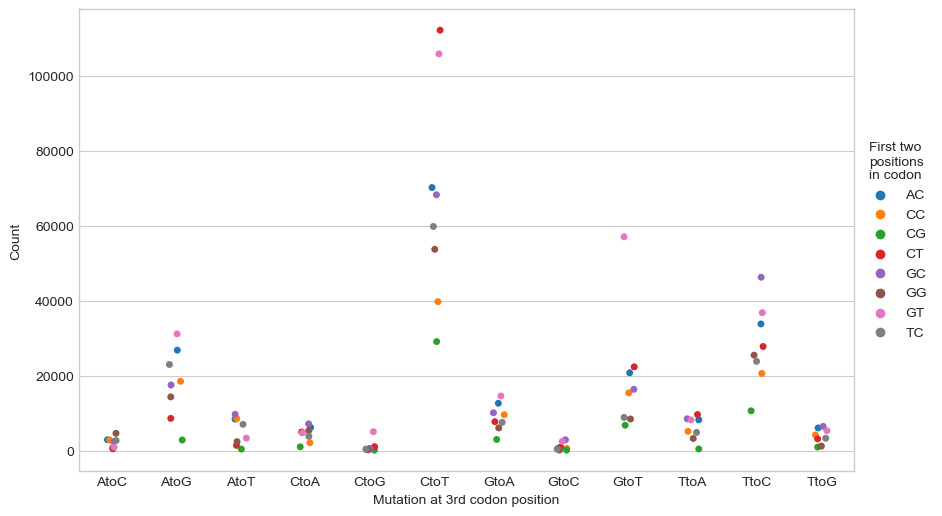

In [173]:
#djp
plt.figure(figsize=(10, 6))
ax = sns.stripplot(df_mut_count_by_codon, hue="codon_pos12", y="count", x="mut_type")
kwds_leg = dict(loc="center left", bbox_to_anchor=(1, 0.5), title="First two\npositions\nin codon")
ax.legend(**kwds_leg)
ax.set_xlabel("Mutation at 3rd codon position")
ax.set_ylabel("Count")
plt.savefig("../results/synonymous_mut_rates/mut_counts_by_codon.png")

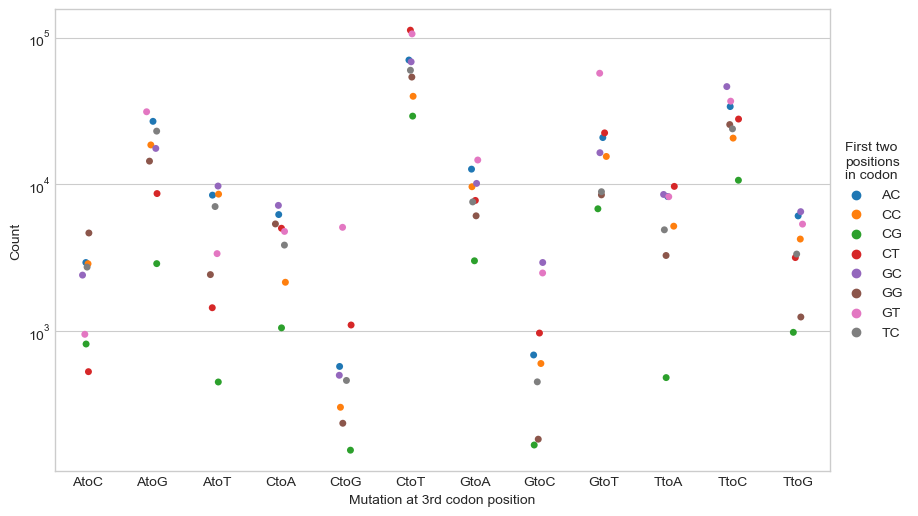

In [174]:
#djp
plt.figure(figsize=(10, 6))
ax = sns.stripplot(df_mut_count_by_codon, hue="codon_pos12", y="count", x="mut_type")
ax.legend(**kwds_leg)
ax.set_xlabel("Mutation at 3rd codon position")
ax.set_ylabel("Count")
ax.set_yscale("log")
plt.savefig("../results/synonymous_mut_rates/mut_counts_by_codon_log.png")

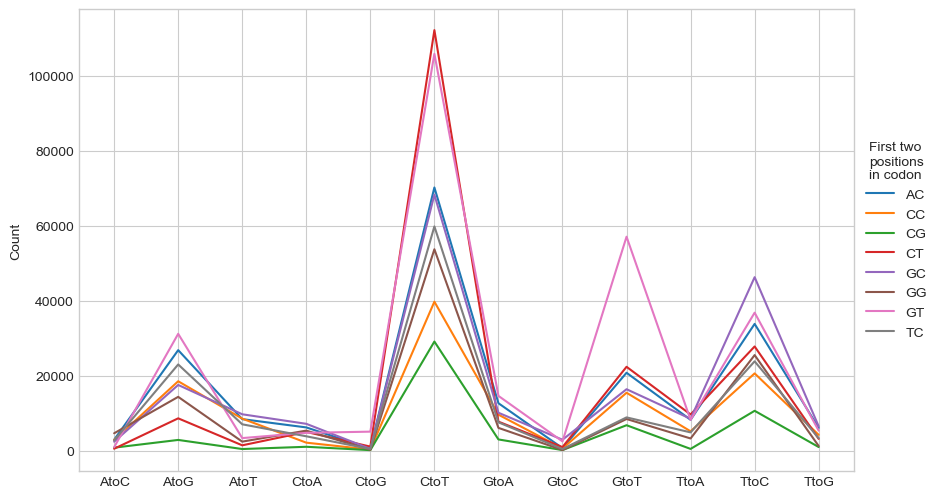

In [177]:
#djp
import numpy as np
plt.figure(figsize=(10, 6))
for pos12 in df_mut_count_by_codon["codon_pos12"].unique():
    sub_df = df_mut_count_by_codon.query("codon_pos12 == @pos12").reset_index()
    sub_df["count"].plot(label=pos12)
plt.xticks(np.arange(len(sub_df)), sub_df["mut_type"])
plt.ylabel("Count")
plt.legend(**kwds_leg)
plt.savefig("../results/synonymous_mut_rates/mut_counts_by_codon_lines.png")

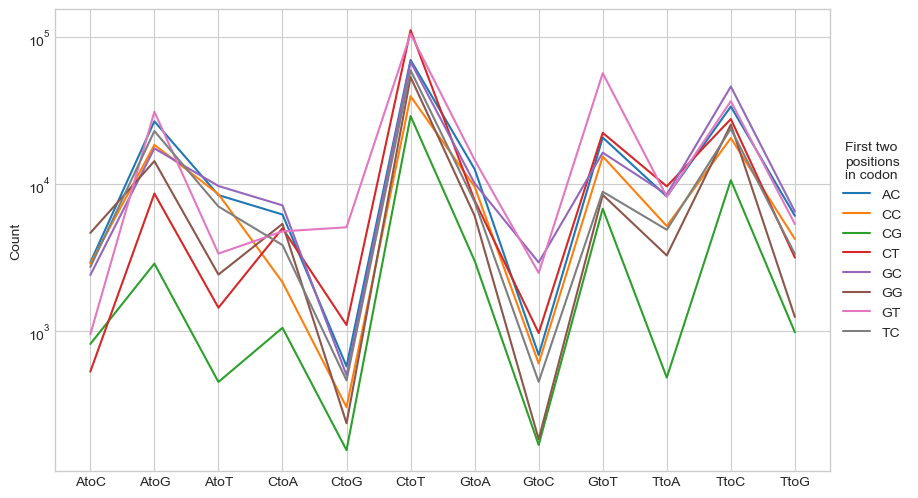

In [179]:
#djp
plt.figure(figsize=(10, 6))
for pos12 in df_mut_count_by_codon["codon_pos12"].unique():
    sub_df = df_mut_count_by_codon.query("codon_pos12 == @pos12").reset_index()
    sub_df["count"].plot(label=pos12)
plt.xticks(np.arange(len(sub_df)), sub_df["mut_type"])
plt.legend(**kwds_leg)
plt.ylabel("Count")
plt.yscale("log")
plt.savefig("../results/synonymous_mut_rates/mut_counts_by_codon_lines_log.png")

For each clade plot the top mutations as a fraction of all mutations in that clade, just using the "all" subset.

You can mouseover points to highlight mutations (which will highlight all mutations at that site on all facets), and click the legend to show/hide excluded or non-excluded mutations.

This plot is useful to look at to identifier apparent outlier sites with aberrantly high mutation counts that can then be specified for exclusion (note those specifications are done in the pipeline `config.yaml` file, and also all reversions from clade founder to reference may be excluded):

In [8]:
top_n = 100  # plot this many per clade

mutation_freqs = (
    mutation_counts.query("subset == 'all'")
    .sort_values(["clade", "count"], ascending=False)
    .groupby("clade")
    .head(n=top_n)
    .assign(
        freq=lambda x: x["count"] / x.groupby("clade")["count"].transform("sum"),
        rank=lambda x: x.groupby("clade")["freq"].rank(ascending=False, method="first"),
        exclude=lambda x: x["exclude"].map({True: "yes", False: "no"}),
    )
)

select_exclude = alt.selection_multi(
    fields=["exclude"],
    bind="legend",
    init=[{"exclude": "yes"}, {"exclude": "no"}],
)

select_site = alt.selection_single(
    fields=["nt_site"],
    on="mouseover",
    empty="none",
)

mutation_freqs_chart = (
    alt.Chart(mutation_freqs)
    .encode(
        x="rank",
        y="freq",
        strokeWidth=alt.condition(select_site, alt.value(2), alt.value(0)),
        color=alt.Color("exclude", scale=alt.Scale(domain=["yes", "no"])),
        shape=alt.Shape("synonymous"),
        size=alt.condition(select_site, alt.value(50), alt.value(25)),
        tooltip=["nt_site", "nt_mutation", "count", "freq"],
    )
    .mark_point(filled=True, stroke="black")
    .properties(width=200, height=100)
    .facet("clade", columns=4)
    .add_selection(select_exclude, select_site)
    .transform_filter(select_exclude)
)

mutation_freqs_chart

alt.FacetChart(...)

Tally mutation type counts among **only four-fold synonymous** mutations for each clade and subset, also removing any mutations specified for exclusion:

In [10]:
mut_type_counts = (
    mutation_counts.query("synonymous")
    .query("four_fold_degenerate")
    .query("not exclude")
    .groupby(["clade", "subset", "mut_type"], as_index=False)
    .aggregate({"count": "sum"})
)
mut_type_counts.head()

,clade,subset,mut_type,count
0,19A,England,AtoC,9
1,19A,England,AtoG,74
2,19A,England,AtoT,20
3,19A,England,CtoA,12
4,19A,England,CtoG,1


Now also repeat these mutation type counts tally, but any mutations in the top 10 most frequent observed mutation for any clade, not doing any subsetting (just taking subset "all"):

In [11]:
exclude_top_n = 5  # exclude mutations in this top rank for any clade

mut_type_counts_exclude_top = (
    mutation_counts.query("synonymous")
    .query("four_fold_degenerate")
    .query("not exclude")
    .query("subset == 'all'")
    .assign(
        clade_rank=lambda x: x.groupby("clade")["count"].rank(
            ascending=False, method="min"
        ),
        highest_rank=lambda x: x.groupby("nt_mutation")["clade_rank"].transform("min"),
    )
    .query("highest_rank > @exclude_top_n")
    .groupby(["clade", "mut_type"], as_index=False)
    .aggregate({"count": "sum"})
)

mut_type_counts_exclude_top.head()

,clade,mut_type,count
0,19A,AtoC,30
1,19A,AtoG,159
2,19A,AtoT,64
3,19A,CtoA,27
4,19A,CtoG,6


Plot total mutation counts for each clade and subset on a log scale.
Also draw a line at our minimum cutoff: we only keep subsets above this cutoff:

In [12]:
clade_counts = mut_type_counts.groupby(["clade", "subset"], as_index=False).aggregate(
    {"count": "sum"}
)

clade_counts_chart = (
    alt.Chart(clade_counts)
    .encode(
        x="clade",
        y=alt.Y("count", title="total mutations", scale=alt.Scale(type="log")),
        tooltip=["clade", "subset", "count"],
        color="subset",
    )
    .mark_circle(size=50, opacity=0.7)
    .properties(width=alt.Step(18), height=175)
)

# draw cutoff line
cutoff = (
    alt.Chart(pd.DataFrame({"y": [synonymous_spectra_min_counts]}))
    .encode(y="y")
    .mark_rule(strokeDash=[2, 2])
)

(clade_counts_chart + cutoff).configure_axis(grid=False)

alt.LayerChart(...)

For genome partitioning, we subdivide the genome into halves based on the first and last site with an observed mutation:

In [27]:
n_partitions = 2

min_site = mutation_counts["nt_site"].min()
max_site = mutation_counts["nt_site"].max() + 1
partition_bounds = numpy.linspace(min_site, max_site, n_partitions + 1)


def assign_partition(r):
    """Assign nucleotide mutation to its partition."""
    for i in range(1, n_partitions + 1):
        if partition_bounds[i - 1] <= r < partition_bounds[i]:
            return f"partition {i}"


mutation_counts = mutation_counts.assign(
    partition=lambda x: x["nt_site"].map(assign_partition)
)
print(mutation_counts.columns)
print(mutation_counts.shape)
mutation_counts.head()

Index(['protein', 'aa_mutation', 'nt_mutation', 'codon_change', 'synonymous',
       'nt_site', 'reference_nt', 'clade_founder_nt', 'exclude',
       'exclude_reason', 'count', 'count_terminal', 'count_non_terminal',
       'mean_log_size', 'clade', 'subset', 'codon', 'codon_position',
       'codon_site', 'four_fold_degenerate', 'mut_type', 'partition'],
      dtype='object')
(1031237, 22)


,protein,aa_mutation,nt_mutation,codon_change,synonymous,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,...,count_non_terminal,mean_log_size,clade,subset,codon,codon_position,codon_site,four_fold_degenerate,mut_type,partition
0,ORF1ab,P5401L,C16466T,CCA>CTA,False,16466,C,C,False,not excluded,...,30,0.709464,19A,all,CCA,2,5401,False,CtoT,partition 2
1,M,I82T,T26767C,ATC>ACC,False,26767,T,T,False,not excluded,...,35,1.160612,19A,all,ATC,2,82,False,TtoC,partition 2
2,ORF1a;ORF1ab,F924F;F924F,C3037T,TTC>TTT;TTC>TTT,True,3037,C,C,False,not excluded,...,24,0.723654,19A,all,TTC;TTC,3;3,924;924,False,CtoT,partition 1
3,ORF1ab,A6319V,C19220T,GCT>GTT,False,19220,C,C,False,not excluded,...,33,1.123765,19A,all,GCT,2,6319,False,CtoT,partition 2
4,ORF1ab,P4715L,C14408T,CCT>CTT,False,14408,C,C,False,not excluded,...,24,0.698993,19A,all,CCT,2,4715,False,CtoT,partition 1


Get PCA of mutation spectrum, using only filtered synonymous mutation counts for non-excluded mutations for clades/subsets/partitions with adequate counts.

We do the PCA on four different ways of partitioning the data:

 1. Just looking at the "all" subset for each clade across entire genome.
 2. Looking at the "all" subset for each clade across entire genome, but excluding any mutation that is among the top ranked most counts for any clade.
 3. Looking at all subsets for each clade across entire genome.
 4. Looking at the "all" subset along partitions of the genome. 

We standardize the vectors of mutation fractions before doing the PCA.

There is also an option, currently not used, to do a composite log ratio (CLR) transform the fraction of all mutations that are each type before performing the PCA, using the formula [here](https://www.rdocumentation.org/packages/compositions/versions/2.0-4/topics/clr) (see [this paper](https://www.jstor.org/stable/2335943)).

In the plots below, you can mouseover the points for details and click on clades in legends (shift click for multiple clades) to highlight just points for the selected clade(s).
You can also use the scroll bar to only show points with at least the indicated number of total synonymous mutation counts (after filtering):

In [15]:
def clr(frac_vec):
    """https://www.rdocumentation.org/packages/compositions/versions/2.0-4/topics/clr"""
    assert all(frac_vec > 0), "does not currently handle zeros in frac_vec"
    return numpy.log(frac_vec) - 1 / len(frac_vec) * numpy.log(frac_vec).sum()


for title, subsets, partition, exclude_top, clr_transform in [
    ("all samples, whole genome", ["all"], False, False, False),
    ("all samples, whole genome, +/- top mutations", ["all"], False, True, False),
    ("by region, whole genome", subset_order, False, False, False),
    ("all samples, partitioned genome", ["all"], True, False, False),
]:

    filtered_mutation_counts = (
        mutation_counts.query("synonymous")
        .query("four_fold_degenerate")
        .query("not exclude")
        .query("subset in @subsets")
    )

    if partition:
        filtered_mutation_counts = pd.concat(
            [
                filtered_mutation_counts.assign(partition="all"),
                filtered_mutation_counts,
            ]
        )
    else:
        filtered_mutation_counts = filtered_mutation_counts.assign(partition="all")

    mut_type_counts = filtered_mutation_counts.groupby(
        ["clade", "subset", "partition", "mut_type"], as_index=False
    ).aggregate({"count": "sum"})

    if exclude_top:
        assert all(mut_type_counts["partition"] == "all")
        assert all(mut_type_counts["subset"] == "all")
        mut_type_counts = pd.concat(
            [
                mut_type_counts.assign(excluded="no"),
                mut_type_counts_exclude_top.assign(
                    partition="all",
                    subset="all",
                    excluded="yes",
                ),
            ]
        )
    else:
        mut_type_counts = mut_type_counts.assign(excluded="no")

    mut_type_freqs = mut_type_counts.assign(
        total_count=lambda x: (
            x.groupby(["clade", "subset", "partition", "excluded"])["count"].transform(
                "sum"
            )
        ),
        freq=lambda x: x["count"] / x["total_count"],
    ).query("total_count >= @synonymous_spectra_min_counts")

    mut_type_freqs = mut_type_freqs.pivot_table(
        index=["clade", "subset", "partition", "excluded", "total_count"],
        values="freq",
        columns="mut_type",
        fill_value=0,
    )

    if clr_transform:
        display(mut_type_freqs)
        mut_type_freqs = mut_type_freqs.apply(clr, axis=1)
        display(mut_type_freqs)

    scaled_freqs = sklearn.preprocessing.StandardScaler().fit_transform(
        mut_type_freqs.values
    )
    pca = sklearn.decomposition.PCA(n_components=2)
    pca_coords = pca.fit_transform(scaled_freqs)
    assert len(pca_coords) == len(mut_type_freqs)

    mut_type_freqs_pca_coords = mut_type_freqs.reset_index().assign(
        principal_component_1=pca_coords[:, 0],
        principal_component_2=pca_coords[:, 1],
        log10_total_count=lambda x: numpy.log(x["total_count"]) / numpy.log(10),
    )

    # percent variance explained by each component
    pca_var = 100 * pca.explained_variance_ratio_

    total_count_selection = alt.selection_single(
        fields=["log10_total_count"],
        init={
            "log10_total_count": numpy.log(synonymous_spectra_min_counts)
            / numpy.log(10)
        },
        bind=alt.binding_range(
            name="minimum log10 total counts",
            min=int(mut_type_freqs_pca_coords["log10_total_count"].min()),
            max=mut_type_freqs_pca_coords["log10_total_count"].max(),
        ),
    )

    clade_selection = alt.selection_multi(fields=["clade"], bind="legend")

    tooltip = ["clade", "total_count"]

    plot_size = 300  # scaled by component variance explained

    pca_chart = (
        alt.Chart(mut_type_freqs_pca_coords)
        .encode(
            y=alt.Y(
                "principal_component_1",
                title=f"PC1 ({pca_var[0]:.0f}% variance)",
                scale=alt.Scale(nice=False, padding=10),
                axis=alt.Axis(labels=False, ticks=False),
            ),
            x=alt.X(
                "principal_component_2",
                title=f"PC2 ({pca_var[1]:.0f}% variance)",
                scale=alt.Scale(nice=False, padding=10),
                axis=alt.Axis(labels=False, ticks=False),
            ),
            color=alt.Color(
                "clade",
                scale=alt.Scale(
                    scheme="viridis",
                    domain=sorted(mut_type_freqs_pca_coords["clade"].unique()),
                ),
            ),
            strokeWidth=alt.condition(clade_selection, alt.value(1.5), alt.value(0)),
            opacity=alt.condition(clade_selection, alt.value(0.9), alt.value(0.45)),
            size=alt.condition(clade_selection, alt.value(65), alt.value(45)),
        )
        .mark_point(filled=True, stroke="black")
        .add_selection(total_count_selection, clade_selection)
        .transform_filter(
            total_count_selection.log10_total_count <= alt.datum.log10_total_count
        )
        .configure_axis(grid=False)
        .configure_legend(columns=2)
        .properties(
            height=plot_size,
            width=plot_size * pca_var[1] / pca_var[0],
            title=title,
        )
    )

    if len(subsets) > 1:
        subset_selection = alt.selection_multi(fields=["subset"], bind="legend")
        pca_chart = (
            pca_chart.encode(
                shape=alt.Shape(
                    "subset", sort=subset_order, scale=alt.Scale(domain=subset_order)
                )
            )
            .add_selection(subset_selection)
            .transform_filter(subset_selection)
        )
        tooltip.append("subset")

    if partition:
        partition_selection = alt.selection_multi(fields=["partition"], bind="legend")
        pca_chart = (
            pca_chart.encode(
                shape=alt.Shape(
                    "partition",
                    scale=alt.Scale(
                        domain=mut_type_freqs_pca_coords["partition"].unique()
                    ),
                ),
            )
            .add_selection(partition_selection)
            .transform_filter(partition_selection)
        )
        tooltip.append("partition")

    if exclude_top:
        exclude_selection = alt.selection_multi(fields=["excluded"], bind="legend")
        pca_chart = (
            pca_chart.encode(
                shape=alt.Shape(
                    "excluded",
                    title=f"excluding top {exclude_top_n} per clade",
                    scale=alt.Scale(
                        domain=mut_type_freqs_pca_coords["excluded"].unique()
                    ),
                ),
            )
            .add_selection(exclude_selection)
            .transform_filter(exclude_selection)
        )
        tooltip.append(
            alt.Tooltip("excluded", title=f"excluding top {exclude_top_n} per clade")
        )

    pca_chart = pca_chart.encode(tooltip=tooltip)

    display(pca_chart)
    print("\n\n")

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

Compute statistical significance of differences between clades.
We just do this on "all" sequences for a clade, not partitioning the genomes:

In [16]:
all_mut_type_counts = (
    mut_type_counts.query("subset == 'all'")
    .drop(columns="subset")
    .assign(total_count=lambda x: x.groupby("clade")["count"].transform("sum"))
    .query("total_count >= @synonymous_spectra_min_counts")
    .drop(columns="total_count")
)

wide_all_mut_type_counts = all_mut_type_counts.pivot_table(
    index="mut_type",
    columns="clade",
    values="count",
    fill_value=0,
)
wide_all_mut_type_counts.head()

clade,20A,20B,20C,20E,20G,20I,20J,21C,21F,21I,21J,21K,21L,22A,22B,22C,22E
mut_type,,,,,,,,,,,,,,,,,
AtoC,190.666667,103.333333,82.000000,91.333333,114.000000,472.000000,30.666667,54.000000,30.666667,233.333333,2902.000000,1052.666667,764.000000,70.666667,479.333333,128.000000,21.333333
AtoG,1078.000000,859.333333,631.333333,736.666667,858.000000,3968.000000,248.000000,378.666667,273.333333,1872.666667,21294.000000,8254.666667,6200.666667,869.333333,4944.000000,1487.333333,320.666667
AtoT,342.666667,268.666667,176.000000,199.333333,307.333333,1161.333333,70.000000,137.333333,95.333333,522.000000,6068.000000,2560.666667,1699.333333,231.333333,1356.000000,350.000000,106.666667
CtoA,226.666667,187.333333,145.333333,142.666667,198.666667,897.333333,58.000000,96.000000,61.333333,436.666667,5317.333333,2083.333333,1686.666667,222.000000,1272.000000,331.333333,88.000000
CtoG,86.666667,56.000000,18.000000,79.333333,24.000000,637.333333,11.333333,17.333333,11.333333,120.000000,2045.333333,507.333333,596.000000,25.333333,156.666667,40.000000,10.666667


Now run chi2 test.
Also, Bonferroni correct the P-values (this is conservative, but is fine as these P-values are so tiny):

In [18]:
min_p = 1e-20  # plot P-values less than this as this

records = []
for clade1, clade2 in itertools.combinations(wide_all_mut_type_counts.columns, 2):
    chi2, p, dof, _ = scipy.stats.chi2_contingency(
        wide_all_mut_type_counts[[clade1, clade2]]
    )
    records.append((clade1, clade2, p, chi2))

chi2_stats = pd.DataFrame(records, columns=["clade_1", "clade_2", "p", "chi2"]).assign(
    p=lambda x: x["p"].clip(lower=min_p),
    bonferroni_p=lambda x: (x["p"] * len(x)).clip(upper=1),
)
chi2_stats.head()

,clade_1,clade_2,p,chi2,bonferroni_p
0,20A,20B,4.489631e-02,20.032547,1.000000e+00
1,20A,20C,6.416744e-03,26.033088,8.726772e-01
2,20A,20E,7.026751e-09,60.647764,9.556381e-07
3,20A,20G,4.464474e-10,67.030184,6.071684e-08
4,20A,20I,4.084743e-19,113.259300,5.555250e-17


Plot the Bonferroni corrected P-values.
Note since counts are very large, many comparisons will be highly significant:

In [20]:
p_chart = (
    alt.Chart(chi2_stats)
    .encode(
        x=alt.X("clade_1", title=None),
        y=alt.Y("clade_2", title=None),
        fill=alt.Fill(
            "bonferroni_p",
            title="Bonferroni corrected P-value",
            scale=alt.Scale(type="log", scheme="yelloworangered", reverse=True),
            legend=alt.Legend(orient="top"),
        ),
        tooltip=[
            "clade_1",
            "clade_2",
            alt.Tooltip("p", format=".2g"),
            alt.Tooltip("bonferroni_p", format=".2g"),
            alt.Tooltip("chi2", format=".2g"),
        ],
    )
    .mark_rect(stroke="black")
    .properties(width=alt.Step(14), height=alt.Step(14))
)

p_chart

alt.Chart(...)

Now get the mutation counts and fractions for each clade, both with and without excluding top mutations.
Then also compute a normalized **rate** for each mutation type, which is the fraction of all mutations that are of that type divided by the overall fraction of 4-fold synonymous sites sites that are the parental nucleotide in the mutation.

Note that a **caveat** is that for these rates we do not adjust the composition to account for any excluded 4-fold synonymous sites.
This is probably not currently a big problem, but could become a concern if a lot of sites are excluded:

In [104]:
parent_composition.head()

,clade,nt,parent_nt_count,parent_nt_frac
0,19A,A,1230,0.289684
1,19A,C,582,0.137070
2,19A,G,276,0.065002
3,19A,T,2158,0.508243
4,20A,A,1230,0.289616


In [22]:
parent_composition = (
    pd.read_csv(clade_founder_nts_csv)
    .query("four_fold_degenerate")
    .groupby(["clade", "nt"], as_index=False)
    .aggregate(parent_nt_count=pd.NamedAgg("site", "nunique"))
    .assign(
        parent_nt_frac=lambda x: (
            x["parent_nt_count"]
            / x.groupby("clade")["parent_nt_count"].transform("sum")
        ),
    )
)

mut_type_count_frac_rate = (
    pd.concat(
        [
            mut_type_counts.query("subset == 'all'")
            .query("partition == 'all'")[["clade", "mut_type", "count"]]
            .assign(exclude_top_mutations="no"),
            mut_type_counts_exclude_top.assign(exclude_top_mutations="yes"),
        ]
    )
    .assign(
        total_count=lambda x: x.groupby(["clade", "exclude_top_mutations"])[
            "count"
        ].transform("sum"),
        fraction=lambda x: x["count"] / x["total_count"],
        parent_nt=lambda x: x["mut_type"].str[0],
    )
    .query("total_count >= @synonymous_spectra_min_counts")
    .merge(
        parent_composition[["clade", "nt", "parent_nt_frac"]].rename(
            columns={"nt": "parent_nt"}
        ),
        how="left",
        validate="many_to_one",
    )
    .assign(rate=lambda x: x["fraction"] / x["parent_nt_frac"])
)

mut_type_count_frac_rate.head()

,clade,mut_type,count,exclude_top_mutations,total_count,fraction,parent_nt,parent_nt_frac,rate
0,20A,AtoC,286,no,17219,0.016610,A,0.289616,0.057350
1,20A,AtoG,1617,no,17219,0.093908,A,0.289616,0.324249
2,20A,AtoT,514,no,17219,0.029851,A,0.289616,0.103070
3,20A,CtoA,340,no,17219,0.019746,C,0.137038,0.144089
4,20A,CtoG,130,no,17219,0.007550,C,0.137038,0.055093


Plot the rates. The chart below is interactive, and you can click to select mutation types, clades, etc:

In [23]:
melted_df = (
    mut_type_count_frac_rate.assign(
        mut_type=lambda x: x["mut_type"].str.replace("to", " -> ")
    )
    .melt(
        id_vars=["clade", "mut_type", "exclude_top_mutations", "count"],
        value_vars=["fraction", "rate"],
    )
    .assign(
        variable=lambda x: x["variable"].map(
            {
                "fraction": "fraction of all mutations",
                "rate": "relative rate of mutation",
            }
        ),
        clade=lambda x: x["clade"].map(lambda c:
            f"{c} ({clade_synonyms[c]})" if c in clade_synonyms else c
        ),
    )
)

mut_type_selection = alt.selection_multi(fields=["mut_type"])

mut_type_selection_bar = (
    alt.Chart(melted_df[["mut_type"]].drop_duplicates())
    .encode(
        x=alt.X("mut_type", title="click / shift-click to select mutation types"),
        color=alt.condition(
            mut_type_selection, alt.value("darkgray"), alt.value("white")
        ),
    )
    .mark_rect(stroke="black")
    .add_selection(mut_type_selection)
    .properties(width=alt.Step(15))
)

frac_rate_chart_base = (
    alt.Chart(melted_df)
    .encode(
        x=alt.X("mut_type", title="mutation type"),
        y=alt.Y("value", title=None),
        color=alt.Color("clade", scale=alt.Scale(scheme="viridis")),
        strokeWidth=alt.condition(clade_selection, alt.value(0.5), alt.value(0)),
        opacity=alt.condition(clade_selection, alt.value(0.9), alt.value(0.2)),
        size=alt.condition(clade_selection, alt.value(50), alt.value(40)),
        column=alt.Column(
            "variable",
            title=None,
            header=alt.Header(
                labelOrient="left", labelFontSize=11, labelFontStyle="bold"
            ),
        ),
        tooltip=[
            alt.Tooltip(c, format=".3g") if melted_df[c].dtype == float else c
            for c in melted_df.columns.tolist()
        ],
    )
    .mark_point(filled=True, stroke="black")
    .add_selection(clade_selection, mut_type_selection)
    .transform_filter(mut_type_selection)
    .resolve_scale(y="independent")
    .properties(width=alt.Step(15), height=200)
)

frac_rate_chart = (
    (frac_rate_chart_base & mut_type_selection_bar)
    .configure_axis(grid=False)
    .configure_legend(columns=2)
    .configure(padding=20)
)

print(f"Saving to {rates_plot}")
frac_rate_chart.save(rates_plot)

frac_rate_chart

Saving to ../results/synonymous_mut_rates/rates_plot.html


alt.VConcatChart(...)

Get rates to write to file.
Get the rates by clade **without** excluding the top mutations:

In [24]:
rates_by_clade = mut_type_count_frac_rate.query("exclude_top_mutations == 'no'").drop(
    columns="exclude_top_mutations"
)

print(f"Writing rates to {rates_by_clade_csv}")
rates_by_clade.to_csv(rates_by_clade_csv, index=False, float_format="%.5g")

rates_by_clade.head()

Writing rates to ../results/synonymous_mut_rates/rates_by_clade.csv


,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate
0,20A,AtoC,286,17219,0.016610,A,0.289616,0.057350
1,20A,AtoG,1617,17219,0.093908,A,0.289616,0.324249
2,20A,AtoT,514,17219,0.029851,A,0.289616,0.103070
3,20A,CtoA,340,17219,0.019746,C,0.137038,0.144089
4,20A,CtoG,130,17219,0.007550,C,0.137038,0.055093
